In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/open.zip"

In [2]:
# v2.2.1 데이콘 리더 보드 점수 => 0.4800326021
# b6에 맞는 이미지 사이즈 조정 필요 => 528

# 최종 수정 2023.05.16 (실행일 동일)
# 해당 코드는 코랩 GPU T4 고용량 RAM에서 실행시킨 결과이며 v2.2.1 버전에서 리팩토링만 진행하였음 

## Import

In [3]:
import pandas as pd
import numpy as np
import random
import glob
import cv2
import re
import os

# pip3 install torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# pip3 install albumentations --user
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# pip3 install torchvision
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import preprocessing
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as mat_plt

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [5]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [7]:
# 학습용 이미지 폴더 경로 수정
# all_img_list = glob.glob(os.path.join(os.path.pardir, os.path.pardir, 'open', 'train', ) + '/*/*')
all_img_list = glob.glob('/content/train/*/*')
print('all_img_list :', all_img_list)

all_img_list : ['/content/train/울음/11.png', '/content/train/울음/15.png', '/content/train/울음/10.png', '/content/train/울음/8.png', '/content/train/울음/21.png', '/content/train/울음/12.png', '/content/train/울음/13.png', '/content/train/울음/5.png', '/content/train/울음/9.png', '/content/train/울음/3.png', '/content/train/울음/17.png', '/content/train/울음/20.png', '/content/train/울음/14.png', '/content/train/울음/2.png', '/content/train/울음/7.png', '/content/train/울음/1.png', '/content/train/울음/6.png', '/content/train/울음/18.png', '/content/train/울음/4.png', '/content/train/울음/0.png', '/content/train/울음/19.png', '/content/train/울음/16.png', '/content/train/반점/2.png', '/content/train/반점/1.png', '/content/train/반점/0.png', '/content/train/훼손/915.png', '/content/train/훼손/1398.png', '/content/train/훼손/688.png', '/content/train/훼손/957.png', '/content/train/훼손/888.png', '/content/train/훼손/106.png', '/content/train/훼손/844.png', '/content/train/훼손/853.png', '/content/train/훼손/850.png', '/content/train/훼손/80.png', '/conte

In [8]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list

# 학습용 이미지 폴더 경로 수정
# df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[4])
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[3])
print('df :', df)

df :                         img_path label
0       /content/train/울음/11.png    울음
1       /content/train/울음/15.png    울음
2       /content/train/울음/10.png    울음
3        /content/train/울음/8.png    울음
4       /content/train/울음/21.png    울음
...                          ...   ...
3452  /content/train/석고수정/33.png  석고수정
3453  /content/train/석고수정/19.png  석고수정
3454  /content/train/석고수정/54.png  석고수정
3455  /content/train/석고수정/45.png  석고수정
3456  /content/train/석고수정/16.png  석고수정

[3457 rows x 2 columns]


In [9]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])
print('train :', train)

train :                         img_path label
1295   /content/train/훼손/879.png    훼손
62     /content/train/훼손/389.png    훼손
294    /content/train/훼손/982.png    훼손
572    /content/train/훼손/348.png    훼손
278    /content/train/훼손/629.png    훼손
...                          ...   ...
918    /content/train/훼손/252.png    훼손
2420   /content/train/오염/576.png    오염
3075   /content/train/면불량/18.png   면불량
740   /content/train/훼손/1245.png    훼손
2783  /content/train/몰딩수정/40.png  몰딩수정

[2419 rows x 2 columns]


## Label-Encoding

In [10]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])
print('train :', train)

train :                         img_path  label
1295   /content/train/훼손/879.png     18
62     /content/train/훼손/389.png     18
294    /content/train/훼손/982.png     18
572    /content/train/훼손/348.png     18
278    /content/train/훼손/629.png     18
...                          ...    ...
918    /content/train/훼손/252.png     18
2420   /content/train/오염/576.png     10
3075   /content/train/면불량/18.png      6
740   /content/train/훼손/1245.png     18
2783  /content/train/몰딩수정/40.png      7

[2419 rows x 2 columns]


## CustomDataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        # TypeError: image must be numpy array type
        # issue: None => 경로에 한글명 존재
        # image = cv2.imread(img_path)
        # print('image :', image)

        # solved
        img_array = np.fromfile(img_path, np.uint8)
        image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
        # print('image :', image)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [12]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [13]:
print('train[img_path].values :', train['img_path'].values)
print('train[label].values :', train['label'].values)
# print('train_transform :', train_transform)

train_dataset = CustomDataset(
    train['img_path'].values, train['label'].values, train_transform)

train_loader = DataLoader(
    train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values,
                            val['label'].values, test_transform)

val_loader = DataLoader(
    val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

train[img_path].values : ['/content/train/훼손/879.png' '/content/train/훼손/389.png'
 '/content/train/훼손/982.png' ... '/content/train/면불량/18.png'
 '/content/train/훼손/1245.png' '/content/train/몰딩수정/40.png']
train[label].values : [18 18 18 ...  6 18  7]


## Model Define

In [14]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b6(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

## Train

In [15]:
def validation(model, criterion, val_loader, device):
    
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):

            imgs = imgs.float().to(device)
            
            # RuntimeError: expected scalar type Long but found Int
            # labels = labels.to(device)

            # solved
            labels = labels.type(torch.LongTensor).to(device) 
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [16]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):

    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None

    val_loss_history = []
    val_score_history = []
    train_loss_history = []
    
    for epoch in range(1, CFG['EPOCHS']+1):

        model.train()
        train_loss = []


        for imgs, labels in tqdm(iter(train_loader)):

            imgs = imgs.float().to(device)

            # RuntimeError: expected scalar type Long but found Int
            # labels = labels.to(device)

            # solved
            labels = labels.type(torch.LongTensor).to(device) 
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        
        val_loss_history.append(_val_loss)
        val_score_history.append(_val_score)
        train_loss_history.append(_train_loss)
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    print('train_loss_history :', train_loss_history)
    mat_plt.plot(range(1, CFG['EPOCHS'] + 1), train_loss_history, 'g')
    mat_plt.title = 'Tranning Loss'
    mat_plt.ylabel('Tranning Loss')
    mat_plt.xlabel('Epochs')
    mat_plt.show()

    print('val_loss_history :', val_loss_history)
    mat_plt.plot(range(1, CFG['EPOCHS'] + 1), val_loss_history, 'r')
    mat_plt.title = 'Validation Loss'
    mat_plt.ylabel('Validation Loss')
    mat_plt.xlabel('Epochs')
    mat_plt.show()

    print('val_score_history :', val_score_history)
    mat_plt.plot(range(1, CFG['EPOCHS'] + 1), val_score_history, 'r')
    mat_plt.title = 'Validation Score'
    mat_plt.ylabel('Validation Score')
    mat_plt.xlabel('Epochs')
    mat_plt.show()

    return best_model

## Run!!

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth
100%|██████████| 165M/165M [00:05<00:00, 31.3MB/s]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.51010] Val Loss : [1.00759] Val Weighted F1 Score : [0.66419]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.39845] Val Loss : [0.78355] Val Weighted F1 Score : [0.77942]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.09700] Val Loss : [1.07352] Val Weighted F1 Score : [0.75113]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.06524] Val Loss : [1.14503] Val Weighted F1 Score : [0.75816]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.06454] Val Loss : [1.38287] Val Weighted F1 Score : [0.72975]
Epoch 00005: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.03856] Val Loss : [1.12358] Val Weighted F1 Score : [0.76646]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.01583] Val Loss : [1.10544] Val Weighted F1 Score : [0.77320]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00718] Val Loss : [1.08573] Val Weighted F1 Score : [0.77447]
Epoch 00008: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00332] Val Loss : [1.06848] Val Weighted F1 Score : [0.78740]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00314] Val Loss : [1.04959] Val Weighted F1 Score : [0.78636]
train_loss_history : [1.5100986785010289, 0.3984453748715551, 0.09700300832475095, 0.06523806958361283, 0.06453945903769254, 0.038564020979193675, 0.015825280342955682, 0.007180338754934431, 0.0033202501188880937, 0.0031386687786787086]


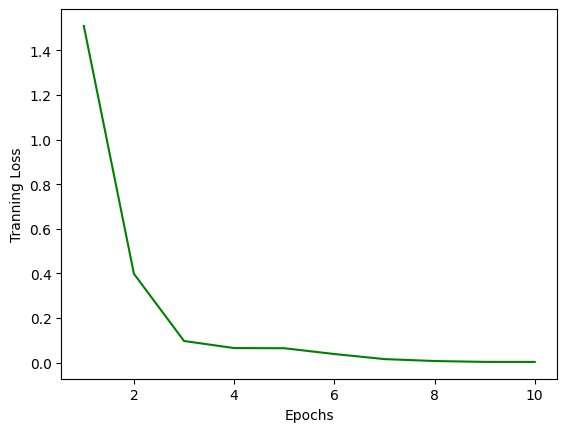

val_loss_history : [1.0075887116518887, 0.7835548687161822, 1.0735203235438375, 1.1450310096596226, 1.3828735324469479, 1.1235775170904216, 1.105435568952199, 1.0857306944601464, 1.0684809472524759, 1.0495939886931218]


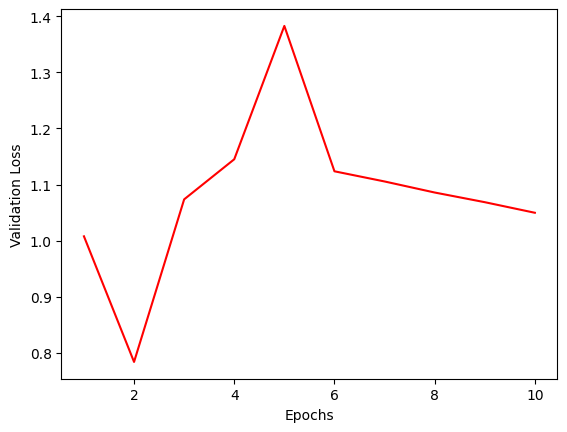

val_score_history : [0.6641928133902785, 0.7794232084481748, 0.7511310167169732, 0.7581592112453551, 0.7297463175667644, 0.7664561649885916, 0.7731951357315537, 0.7744731746777931, 0.7873988988901903, 0.7863553740345816]


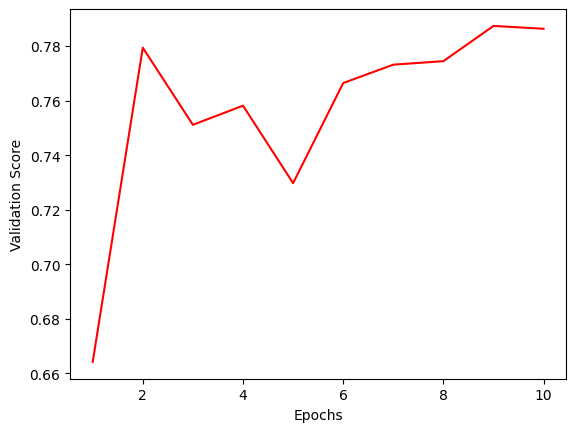

In [17]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

## Inference

In [18]:
# 테스트 csv 파일 경로 수정
# test = pd.read_csv('../../open/test.csv')
test = pd.read_csv('/content/test.csv')

In [19]:
# ======== 테스트 이미지 파일 경로 수정 ========

# test_img_paths = []

# for i in test['img_path'].values:

#     test_img_path = '../../open/' + i.replace('./', '')

#     test_img_paths.append(test_img_path)

# print('test_img_paths :', test_img_paths)

# test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)

# =============================================

test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [20]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [21]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

## Submission

In [22]:
# 제출용 추론 결과 csv 파일 경로 수정
# submit = pd.read_csv('../../open/sample_submission.csv')
submit = pd.read_csv('/content/sample_submission.csv')

In [23]:
submit['label'] = preds

In [24]:
submit.to_csv('./v2_baseline_submit.csv', index=False)

In [25]:
print('predicted_defect_types :')
print(submit['label'].value_counts())

predicted_defect_types :
훼손         340
오염         214
터짐          44
꼬임          37
오타공         33
몰딩수정        25
면불량         23
곰팡이         18
들뜸          18
걸레받이수정      13
피스           9
석고수정         7
이음부불량        3
창틀,문틀수정      3
울음           3
녹오염          1
가구수정         1
Name: label, dtype: int64


In [2]:
# v2.2.1 csv 파일과 비교
predicted_defect_types = pd.read_csv('v2_2_1_baseline_submit.csv')
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
label
훼손         345
오염         209
터짐          64
꼬임          39
오타공         25
몰딩수정        24
걸레받이수정      17
곰팡이         15
면불량         14
창틀,문틀수정      9
피스           9
녹오염          5
이음부불량        5
울음           4
들뜸           4
석고수정         2
가구수정         1
틈새과다         1
Name: count, dtype: int64
